# Minimum Buy-in

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. In this notebook, we minimize the variance (risk) of the portfolio, constraining the expected return to meet a prescribed minimum level. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

To this basic model, we add *buy-in thresholds* that prevent the investor from holding tiny positions. Holding tiny positions is undesirable because they have a marginal, if any, impact on the expected return but can lead to non-negligible transaction costs, which are not accounted for in the portfolio selection model.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulation
The model minimizes the variance of the portfolio given that the minimum level of expected return is attained and that each position is above a specified lower bound to avoid triggering brokerage costs with tiny positions.

Mathematically, this results in a convex quadratic mixed-integer optimization problem.

### Model Parameters
We use the following parameters:

- $\bar\mu$: required expected portfolio return
- $\ell > 0$: minimal position size

In [5]:
# Values for the model parameters:
r = 0.25  # Required expected return
l = 0.03  # Minimal position size

### Decision Variables and Variable Bounds
The decision variables in the model are the proportions of capital invested among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.


We will declare the variables to be *semi-continuous*, meaning either $$x_i=0\ \text{or}\ 0<\ell \leq x_i \leq 1\; , \; i \in S.$$

###  Constraints
The budget constraint ensures that all capital is invested:

$$\sum_{i \in S} x_i =1 $$

The expected return of the portfolio must be at least $\bar\mu$:

$$\mu^\top x \geq \bar\mu$$

###  Objective Function
The objective is to minimize the risk of the portfolio, which is measured by its variance:

$$\min_x x^\top \Sigma x$$


Using gurobipy, this can be expressed as follows:

In [6]:
%%capture
# Create an empty optimization model
m = gp.Model("Portfolio")

# Add variables: x[i] denotes the proportion invested in stock i. Must be greater or equal to l or zero.
# Defining the variable as semi-continuous is enough to enforce the buy-in threshold requirement.
x = m.addMVar(len(mu), lb=l, ub=1, vtype=gp.GRB.SEMICONT, name="x")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")

# Lower bound on expected return
m.addConstr(mu.to_numpy() @ x >= r, name="Minimal_Return")

# Define objective function: Minimize risk
m.setObjective(x @ Sigma.to_numpy() @ x, gp.GRB.MINIMIZE)

We now solve the optimization problem:

In [7]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 2 rows, 462 columns and 924 nonzeros


Model fingerprint: 0x3e0b16ed


Model has 106953 quadratic objective terms


Variable types: 0 continuous, 0 integer (0 binary)


Semi-Variable types: 462 continuous, 0 integer


Coefficient statistics:


  Matrix range     [7e-02, 1e+00]


  Objective range  [0e+00, 0e+00]


  QObjective range [6e-03, 2e+02]


  Bounds range     [3e-02, 1e+00]


  RHS range        [2e-01, 1e+00]


Presolve time: 0.05s


Presolved: 926 rows, 924 columns, 2771 nonzeros


Presolved model has 106953 quadratic objective terms


Variable types: 462 continuous, 462 integer (462 binary)


Found heuristic solution: objective 10.5757854


Root relaxation: objective 2.026597e+00, 154 iterations, 0.01 seconds (0.01 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0    2.02660    0   37   10.57579    2.02660  80.8%     -    0s


H    0     0                       2.1009626    2.02660  3.54%     -    0s


H    0     0                       2.0344360    2.02660  0.39%     -    0s


     0     0    2.02660    0   28    2.03444    2.02660  0.39%     -    0s


     0     0    2.02660    0   28    2.03444    2.02660  0.39%     -    0s


     0     0    2.02660    0   28    2.03444    2.02660  0.39%     -    0s


     0     0    2.02697    0   27    2.03444    2.02697  0.37%     -    0s


     0     0    2.02697    0   27    2.03444    2.02697  0.37%     -    0s


     0     0    2.02798    0   27    2.03444    2.02798  0.32%     -    0s


     0     1    2.02798    0   26    2.03444    2.02798  0.32%     -    0s


Cutting planes:


  Implied bound: 2


  MIR: 3


Explored 85 nodes (713 simplex iterations) in 0.30 seconds (0.21 work units)


Thread count was 2 (of 2 available processors)


Solution count 4: 2.03444 2.03624 2.10096 10.5758 


Optimal solution found (tolerance 1.00e-04)


Best objective 2.034435973118e+00, best bound 2.034263875958e+00, gap 0.0085%


We print out the optimal solution and objective value:

In [8]:
# Display basic solution data
print(f"Minimum Risk:     {m.ObjVal:.6f}")
print(f"Expected return:  {mu @ x.X:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e. >1e-5)
positions = pd.Series(name="Position", data=x.X, index=mu.index)
print(f"Number of trades: {positions[positions > 1e-5].count()}\n")
print(positions[positions > 1e-5])

Minimum Risk:     2.034436
Expected return:  0.250000
Solution time:    0.30 seconds

Number of trades: 23

KR      0.030000
PGR     0.044192
CME     0.030000
ODFL    0.030000
BDX     0.030000
LIN     0.030000
KDP     0.077162
GILD    0.030000
CLX     0.056940
SJM     0.030000
LLY     0.103001
DPZ     0.054447
MKTX    0.030000
MRK     0.036542
ED      0.084887
WST     0.030000
TMUS    0.033931
NOC     0.030000
WM      0.045810
TTWO    0.036782
WMT     0.064940
HRL     0.031366
CPB     0.030000
Name: Position, dtype: float64


## Comparison with the unconstrained portfolio

We can also compute the portfolio without the minimum buy-in condition by changing the variable type and bounds of $x$ and compare the resulting portfolios.

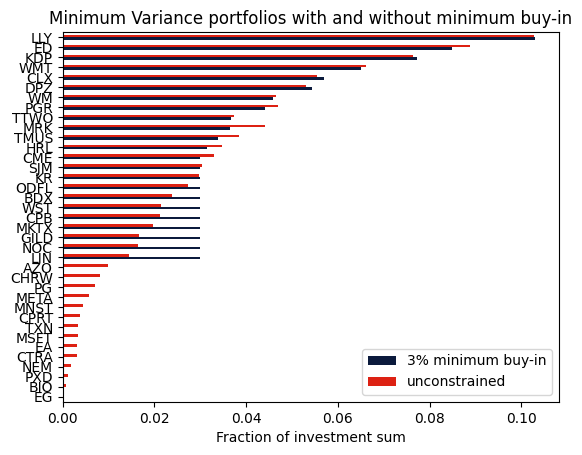

In [9]:
# change type of x from semi-continous to continuous
x.vtype = gp.GRB.CONTINUOUS
x.lb = 0
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
mask = (positions > 1e-5) | (x.X > 1e-5)
df = pd.DataFrame(
    index=positions[mask].index,
    data={
        "3% minimum buy-in": positions,
        "unconstrained": x.X[mask],
    },
).sort_values(by=["3% minimum buy-in", "unconstrained"], ascending=True)

axs = df.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without minimum buy-in")
plt.show()

## Takeaways
* Semi-continuous variables are decision variables that may either take the value 0 or a value between specified bounds. They are a convenient tool to guarantee a minimum position size for purchased assets.